## Summative Coursework - Experiments Investigating PRSH 

In [126]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import pandas as pd
import importlib

import BSE
importlib.reload(BSE) # important to ensure most recent version of BSE used 
from BSE import market_session, set_PRSH_parameters

# graphing functions from BSE Intro Practical 


# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks, title):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    plt.title(title)
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode, title):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks, title) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

### Analysing How Changes In k Affect Behaviour
#### Market Conditions
I choose to emulate market conditions used by Vytelingum and Cliff/Snashall, inspired by Smith as these are well-documented experimental conditions believed to be varied enough to make strong claims about the ability of algorithms.

I also take inspiration from IBMs experiments, testing both balanced-group and one-to-many trader sets.

To change the k parameter I have written an extra function in BSE that sets a global variable to the k value.

In [107]:
# Experimental setup

trials_per_k = 10 # important for valid results as PRSH is stochastic 

balanced_sellers_spec = [("ZIP", 5),("ZIC", 5),("PRSH", 5), ("SHVR", 5), ("GVWY", 5)]
balanced_buyers_spec = balanced_sellers_spec
balanced_traders_spec = {"sellers":balanced_sellers_spec, "buyers":balanced_buyers_spec}

start_time = 0
end_time = 3600 

max_k = 10
min_k = 2

def csv_prep(fname, total_traders):
    dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
    tdump = open(dir + fname, 'w')

    # annotate columns
    tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
    for f in range(total_traders):
            tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
    tdump.write('%s, %s, ' % ('best bid','best offer'))
    tdump.write('\n');
    return tdump



In [110]:
## M1 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval

# CSV preparation

fname = 'balanced_market_output_m1.csv'
tdump = csv_prep(fname, total_traders = 6)

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
k_iteration = 0
for k in range(min_k, max_k):
        k_iteration += 1
        set_PRSH_parameters(k)
        while trial < k_iteration * trials_per_k:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  


In [111]:
## M2 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval
# CSV preparation

fname = 'balanced_market_output_m2.csv'
tdump = csv_prep(fname, total_traders = 6)

sup_range = (10, 50)
dem_range = (25, 35)

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':end_time, "ranges":[dem_range], "stepmode":"fixed"}]

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
k_iteration = 0 
for k in range(min_k, max_k):
        k_iteration += 1
        set_PRSH_parameters(k)
        while trial < k_iteration * trials_per_k:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  


In [112]:
# MS14 experiment
# CSV preparation

fname = 'balanced_market_output_ms14.csv'
tdump = csv_prep(fname, total_traders = 6)

sup_range = (10, 50)
dem_range = (10, 50)
sup_range_shock = (20, 60)
dem_range_shock = (20, 60)

mid_time = end_time/2

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':end_time, "ranges":[dem_range], "stepmode":"fixed"}]

supply_schedule = [{'from':start_time, 'to':mid_time, "ranges":[sup_range], "stepmode":"fixed"}, {'from':mid_time, 'to':end_time, "ranges":[sup_range_shock], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':mid_time, "ranges":[dem_range], "stepmode":"fixed"}, {'from':mid_time, 'to':end_time, "ranges":[dem_range_shock], "stepmode":"fixed"}]

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
k_iteration = 0 
for k in range(min_k, max_k):
        k_iteration += 1
        set_PRSH_parameters(k)
        while trial < k_iteration * trials_per_k:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  


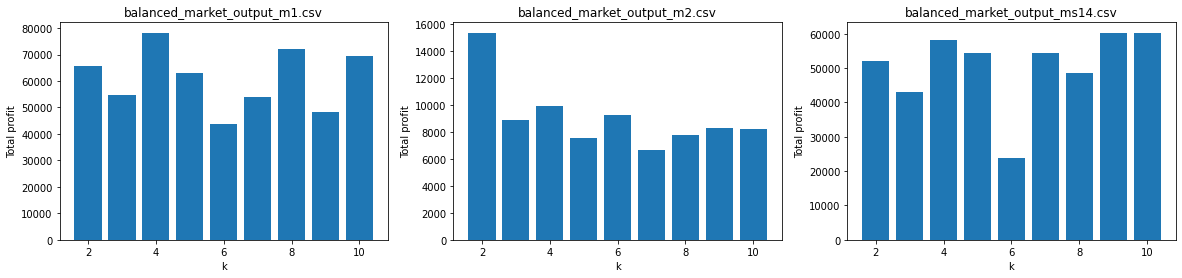

In [113]:
## Visualising
csvs = ['balanced_market_output_m1.csv', 'balanced_market_output_m2.csv', 'balanced_market_output_ms14.csv']

fig, axs = plt.subplots(figsize=(20,4), nrows=1, ncols=3)

target = zip(csvs, axs.flatten())
for (csv1, ax) in target:

    trades_df = pd.read_csv(csv1)
    trades_df = trades_df.assign(k = np.repeat(np.arange(min_k, max_k + 1), trials_per_k))

    # Just PRSH performance, grouped by k values
    PRSH_df = trades_df.iloc[:,8:10]
    PRSH_df = PRSH_df.assign(k = np.repeat(np.arange(min_k, max_k + 1), trials_per_k ))
    groups = PRSH_df.groupby(pd.Grouper(key='k')).sum()
    
    for key in groups:
        ax.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
        ax.set_title(csv1)
        ax.set_ylabel("Total profit")
        ax.set_xlabel("k")
        
plt.show()


In [114]:
# Pairwise comparison against ZIP, M1 conditions changing ratios, ks

for i in range(min_k, max_k):
    fname = 'pairwise_output_m1_' + str(i) + '.csv'
    tdump = csv_prep(fname, total_traders = 2)

    set_PRSH_parameters(k)

    total_traders = 5
    trials_per_k = 5
    trials_per_ratio = 5
    trial = 0
    k_iteration = 0
    for j in range (1, total_traders):
        sellers_spec = [("ZIP", j), ("PRSH", total_traders - j)]
        buyers_spec = sellers_spec
        traders_spec = {"sellers": sellers_spec, "buyers": buyers_spec}

        sup_range = (10, 50)
        dem_range = sup_range

        supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
        demand_schedule = supply_schedule

        order_interval = 10
        order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}
        k_iteration += 1
        while trial <  k_iteration * trials_per_ratio:
                market_session(trial, start_time, end_time, traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1 



0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

1

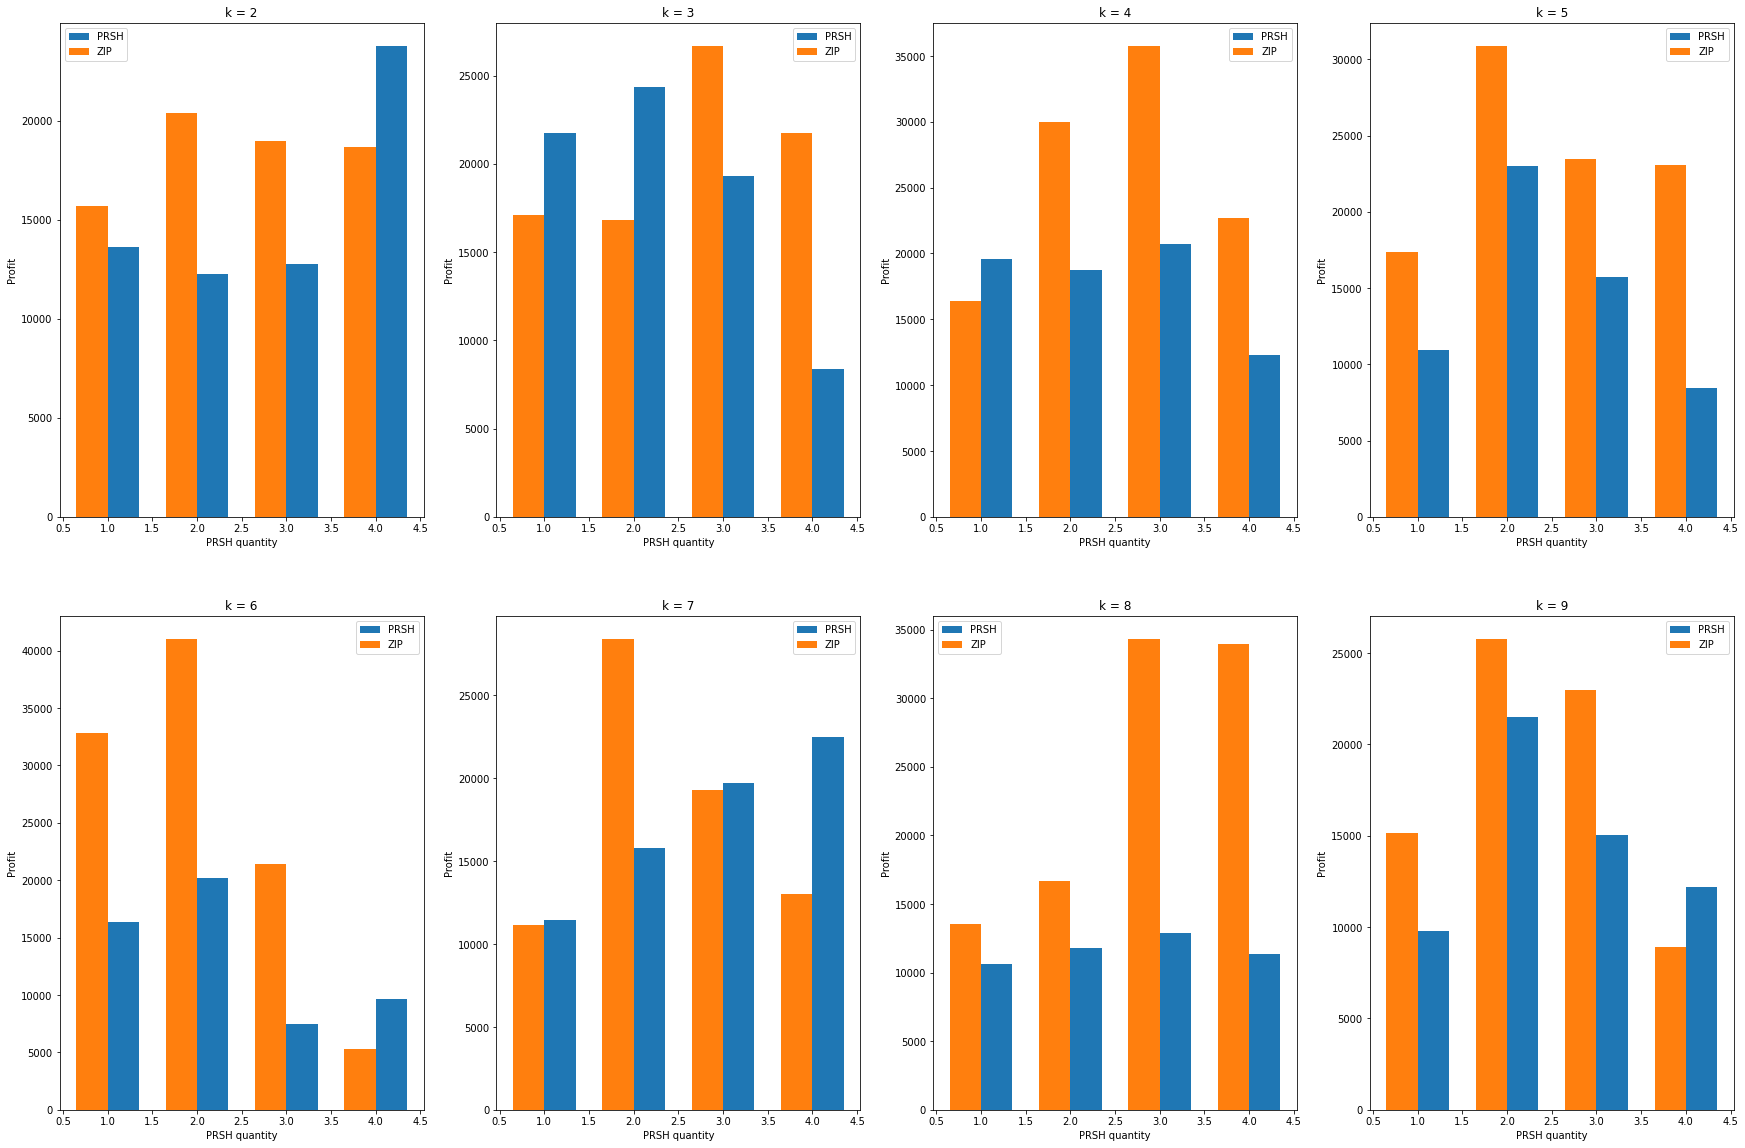

In [115]:
fig, axs = plt.subplots(2,4,figsize=(30,20))

for i, ax in zip(range (min_k, max_k), axs.ravel()):
    trades_df = pd.read_csv('pairwise_output_m1_' + str(i) + '.csv')
    trades_df.columns = trades_df.columns.str.strip()

    trades_df = trades_df.loc[:,['balance', 'number of traders', 'balance.1']]

    groups = trades_df.groupby(pd.Grouper(key='number of traders')).sum()

    label1 = "PRSH"
    width = 0.35
    for key in groups:
        ax.bar(groups.get(key).index.to_numpy()/2 + width/2, groups.get(key).values, np.abs(width), label = label1)
        ax.set_title("k = " + str(i))
        ax.set_xlabel("PRSH quantity")
        ax.set_ylabel("Profit")
        width = -width
        label1 = "ZIP"
        ax.legend()
plt.show()

Conclusion: 
No relationship between performance and k. Only result where k significantly improved performance was k = 2 in m2. 
It also rarely outperforms ZIP regardless of parameters/ratios
# TODO: statistical testing to test whether significiantly different

### Analysing How Changing the Mutation Function Affects Behaviour For Set k

Choosing optimal k found in the previous step.
Then try a less optimal k to see if performance can be made on par with the optimal k - relationship between mutation function and k?

Different mutation functions:
- fixed step
- uniform steps
- uniform where half increase/half decrease
- gradient descent inspired? step in direction of most improvement 

Uniform rather than Gaussian means less likely to stay near current s

In [143]:
def default(s, k):
    sdev = 0.05
    newstrat = s
    while newstrat == s:
        newstrat = s + random.gauss(0.0, sdev)  # 
        newstrat = max(-1.0, min(1.0, newstrat)) # clipping to within correct range
    return newstrat
    
def fixed_step_mutate(s, k):
    step_size = 0.1
    # random direction
    dir = random.choice([True, False])
    if dir: return min(1.0, s + step_size)
    else: return max(-1, s - step_size)
    
def uniform_step_mutate(s, k):
    lower = -0.1
    upper = 0.1
    newstrat = s
    while newstrat == s:
        newstrat = s + random.uniform(lower, upper)  # uniform instead of Gaussian 
        newstrat = max(-1.0, min(1.0, newstrat)) # clipping to within correct range
    return newstrat

def uniform_halves(s, k):
    # requires altering BSE? #TODO: test if self.k works
    upper = 0.1
    newstrat = s
    while newstrat == s:
        if s > k / 2: return min(1, s + random.uniform(0, upper))
        else: return max(-1, s - random.uniform(0, upper))

def uniform_small_big(s, k):
    small_up = 0.05
    big_up = 0.15

    newstrat = s
    while newstrat == s:
        if s > k / 2: return  max(-1.0, min(1.0, s + random.uniform(-small_up, small_up) ))
        else: return  max(-1.0, min(1.0, s + random.uniform(-big_up, big_up)))
    


In [144]:
# Comparing each in m1 conditions

## M1 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval

# CSV preparation

dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
fname = 'mutate_balanced_m1.csv'
tdump = open(dir + fname, 'w')

# annotate columns
tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
for f in range(6):
        tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
tdump.write('%s, %s, ' % ('best bid','best offer'))
tdump.write('\n');


mutate_funcs = [default, fixed_step_mutate, uniform_step_mutate, uniform_halves, uniform_small_big]

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
trials_per_mutate = 5
func_no = 0

for func in mutate_funcs:
        func_no += 1
        set_PRSH_parameters(k1 = 3, mutate1 = func)
        while trial < func_no * trials_per_mutate:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1





0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  


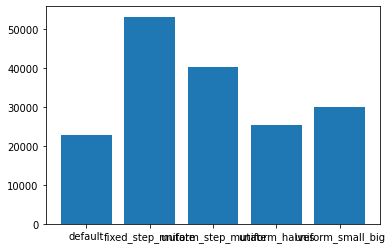

In [146]:
## Visualising
dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
csv1 = 'mutate_balanced_m1.csv'

trades_df = pd.read_csv(dir + csv1)

# Just PRSH performance, grouped by k values
PRSH_df = trades_df.iloc[:,8:10]
PRSH_df = PRSH_df.assign(mutate = np.repeat(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], trials_per_mutate))
groups = PRSH_df.groupby(pd.Grouper(key='mutate')).sum()

for key in groups:
    plt.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
    

plt.show()



0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  


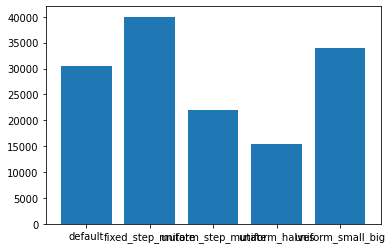

In [149]:
# different k:
# Comparing each in m1 conditions

## M1 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval

# CSV preparation

dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
fname = 'mutate_balanced_m1_k6.csv'
tdump = open(dir + fname, 'w')

# annotate columns
tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
for f in range(6):
        tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
tdump.write('%s, %s, ' % ('best bid','best offer'))
tdump.write('\n');


mutate_funcs = [default, fixed_step_mutate, uniform_step_mutate, uniform_halves, uniform_small_big]

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
trials_per_mutate = 5
func_no = 0

for func in mutate_funcs:
        func_no += 1
        set_PRSH_parameters(k1 = 6, mutate1 = func)
        while trial < func_no * trials_per_mutate:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1

## Visualising
dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
csv1 = 'mutate_balanced_m1_k6.csv'

trades_df = pd.read_csv(dir + csv1)

# Just PRSH performance, grouped by k values
PRSH_df = trades_df.iloc[:,8:10]
PRSH_df = PRSH_df.assign(mutate = np.repeat(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], trials_per_mutate))
groups = PRSH_df.groupby(pd.Grouper(key='mutate')).sum()

for key in groups:
    plt.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
    

plt.show()




0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  


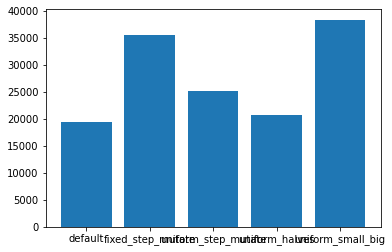

In [150]:
# Different market

# ms14

# CSV preparation

dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
fname = 'mutate_balanced_ms14.csv'
tdump = open(dir + fname, 'w')

# annotate columns
tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
for f in range(6):
        tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
tdump.write('%s, %s, ' % ('best bid','best offer'))
tdump.write('\n');


mutate_funcs = [default, fixed_step_mutate, uniform_step_mutate, uniform_halves, uniform_small_big]

sup_range = (10, 50)
dem_range = (10, 50)
sup_range_shock = (20, 60)
dem_range_shock = (20, 60)

mid_time = end_time/2

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':end_time, "ranges":[dem_range], "stepmode":"fixed"}]

supply_schedule = [{'from':start_time, 'to':mid_time, "ranges":[sup_range], "stepmode":"fixed"}, {'from':mid_time, 'to':end_time, "ranges":[sup_range_shock], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':mid_time, "ranges":[dem_range], "stepmode":"fixed"}, {'from':mid_time, 'to':end_time, "ranges":[dem_range_shock], "stepmode":"fixed"}]

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}
trial = 0
trials_per_mutate = 5
func_no = 0

for func in mutate_funcs:
        func_no += 1
        set_PRSH_parameters(k1 = 3, mutate1 = func)
        while trial < func_no * trials_per_mutate:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1

## Visualising
dir = r'C:\Users\Joe\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
csv1 = 'mutate_balanced_ms14.csv'

trades_df = pd.read_csv(dir + csv1)

# Just PRSH performance, grouped by k values
PRSH_df = trades_df.iloc[:,8:10]
PRSH_df = PRSH_df.assign(mutate = np.repeat(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], trials_per_mutate))
groups = PRSH_df.groupby(pd.Grouper(key='mutate')).sum()

for key in groups:
    plt.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
    

plt.show()



### Analysing an Adapted PRSH Trader

In [ ]:
# import improved PRSH from separate file
# analyse how changing parameters affect it in similar way to above?
# compare optimised parameter EPRSH and PRSH in each market to compare performance?